This notebook covers:
* Probable flight path inference using Gaussian process variational inference
* Loading and processing data from bumBLEbee tracking system
* Infering angles from bumBLEbee tracking system
* Making prediction of flight path using VI from inferred angles

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import scipy.stats as sci

# Path Inference w/ Synthetic Test

Gaussian process variational inference to predict a probable flight path from bearings (in radians) from given locations over time.

Helper functions:

In [6]:
# Cross product of a & b
def crossProduct(a, b):
    size = a.shape[0]
    A = tf.Variable([[tf.zeros(size), -a[:, 2], a[:, 1]], [a[:, 2], tf.zeros(size), -a[:, 0]], [-a[:, 1], a[:, 0], tf.zeros(size)]])
    A = tf.transpose(A, [2, 0, 1])
    A = A[None, :, :, :]
    b = b[:, :, :, None]
    return (A@b)[:,:,:,0]

# Borrowed confidence ellipse function
def confidence_ellipse(mean, cov, ax, n_std=3.0, fill=False, **kwargs):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, fill=fill, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])
    ellipse.set_transform(transf + ax.transData)
    return ellipse

EQ Kernel:
$$K(\mathbf{x}, \mathbf{x}') = \text{exp}\Big(-\frac{|\mathbf{x}-\mathbf{x}'|^2}{2l^2}\Big)$$

In [8]:
class ExponentiatedQuadratic:
    def __init__(self, lengthScale, scaleFactor):
        self.lengthScale = lengthScale
        self.scaleFactor = scaleFactor
        
    def K(self, X, Xprime):
        # EQ kernel: scale^2 * exp((-(x-x')^2) / (2*ls^2))
        covariance = (self.scaleFactor ** 2) * np.exp(-np.sum((np.subtract(X[:, None], Xprime[None, :])) ** 2 / (2 * self.lengthScale ** 2), 2))
        axsel = tf.cast((X[:,1][:,None]==Xprime[:,1][None,:]), dtype=tf.float32)
        covariance *= axsel
        return covariance

VI object, iteratively optimises surrogate posterior distribution,
$$\mathcal{GP}(K_{*f} K_{ff}^{-1} y, K_{**} - K_{*f} K_{ff}^{-1} K_{f*})$$
using the gradient of the ELBO,
$$\mathcal{L} = \mathbb{E}_{q(X,\theta)}[\textup{log }p_{\gamma}(y|X)] - D_{KL}[q_{\psi}(\theta)||p_{\gamma}(\theta)].$$

In [10]:
class Path:
    def __init__(self, observationTimes, observations, kernel, noiseScale, numberOfInducingPoints, inducingPointRange):
        self.observations = observations # Angle observations made
        self.observationTimes = observationTimes # Times observations were made at
        self.noiseScale = noiseScale # Noise scale of likelihood
        self.kernel = kernel # Kernel function
        self.inducingPointRange = inducingPointRange # Range outside the time series that inducing points are selected from/to
        self.jitter = 0 # Jitter applied to covariance matrix during training
        self.mean = [] # Posterior mean
        self.covariance = [] # Posterior covariance\
        self.Z = self.SelectInducingPoints(numberOfInducingPoints) # Select inducing points
        self.lossHistory = []

    # Get inducing points between +/- a percentage of the time observations were made at
    def SelectInducingPoints(self, numInducingPoints):
        max_time = np.max(self.observationTimes) + ((np.max(self.observationTimes) - np.min(self.observationTimes))
                                                    * self.inducingPointRange)
        min_time = np.min(self.observationTimes) - ((np.max(self.observationTimes) - np.min(self.observationTimes))
                                                    * self.inducingPointRange)
        
        inputMatrix = []
        # Evenly spaced inducing points
        for vectorObserved in range(int(self.observations.shape[1] / 2)):
            inputMatrixEntry = np.c_[np.linspace(min_time, max_time, numInducingPoints), np.full(numInducingPoints, vectorObserved)]
            inputMatrix.extend(inputMatrixEntry)
        return tf.Variable(np.array(inputMatrix), dtype=tf.float32)   
    
    # Make predictions at evenly spaced times
    def Inference(self, numOfPredictions):
        # GP(Kzx Kzz^-1 y, Kzz - Kzx Kxx^-1 Kxz)
        Xs = self.SelectInducingPoints(numOfPredictions)
        Kzz = self.kernel.K(self.Z, self.Z) + (np.eye(self.Z.shape[0], dtype=np.float32) * self.jitter)
        Kxx = self.kernel.K(Xs, Xs) + (np.eye(Xs.shape[0], dtype=np.float32) * self.jitter)
        Kxz = self.kernel.K(Xs, self.Z)
        Kzx = tf.transpose(Kxz)
        KzzinvKzx = tf.linalg.solve(Kzz, Kzx)
        KxzKzzinv = tf.transpose(KzzinvKzx)
        KxzKzzinvKzx = Kxz @ KzzinvKzx

        numInputs = int(Xs.shape[0] / int(self.observations.shape[1] / 2))
        mean = tf.transpose(tf.reshape((KxzKzzinv @ self.mean)[:, 0], [int(self.observations.shape[1] / 2), numInputs]), [1, 0])
        covariance = tf.transpose(tf.concat([(Kxx - KxzKzzinvKzx + KxzKzzinv @ (self.covariance @ tf.transpose(self.covariance)) @ KzzinvKzx)
                                      [i::numInputs, i::numInputs][:, :, None] for i in range(numInputs)], axis=2), [2, 0, 1])
        
        return mean, covariance

    # Perform VI - iteratively optimise a surrogate GP to most closely resemble the intractable true posterior distribution using
    # the gradient of the ELBO at each step.
    def Train(self, iterations=500, learningRate=0.15, numOfSamples = 100):
        X = tf.Variable(np.c_[np.tile(self.observationTimes, int(self.observations.shape[1] / 2))[:, None],
                        np.repeat(np.arange(int(self.observations.shape[1] / 2)), len(self.observationTimes), axis=0)], dtype=tf.float32)
        y = tf.Variable(self.observations, dtype = tf.float32)
        
        optimiser = tf.keras.optimizers.Adam(learning_rate = learningRate)

        # Number of inducing points & inputs
        numInducingPoints = self.Z.shape[0]
        numInputs = int(X.shape[0] / int(self.observations.shape[1] / 2))
        
        # Mean of "surrogate" posterior
        surrogateMean = tf.Variable(tf.random.normal([numInducingPoints, 1]))
        # Use diagonal of covariance matrix for LU decomposition during iterative optimisation
        surrogateLowerDiagonal = tf.Variable(np.tril(0.01 * np.random.randn(numInducingPoints,numInducingPoints) + 1 * 
                                                     np.eye(numInducingPoints)), dtype=tf.float32)       

        # Prior distribution using K
        priorMean = tf.zeros([1, numInducingPoints])
        priorCovariance = tf.Variable(self.kernel.K(self.Z, self.Z))
        prior = tfd.MultivariateNormalFullCovariance(priorMean, priorCovariance + (np.eye(priorCovariance.shape[0]) * self.jitter))

        # GP(Kzx Kzz^-1 y, Kzz - Kzx Kxx^-1 Kxz)
        Kzz = self.kernel.K(self.Z, self.Z) + (np.eye(self.Z.shape[0], dtype=np.float32) * self.jitter)
        Kxx = self.kernel.K(X, X) + (np.eye(X.shape[0], dtype=np.float32) * self.jitter)
        Kxz = self.kernel.K(X, self.Z)
        Kzx = tf.transpose(Kxz)
        KzzinvKzx = tf.linalg.solve(Kzz, Kzx)
        KxzKzzinv = tf.transpose(KzzinvKzx)
        KxzKzzinvKzx = Kxz @ KzzinvKzx

        # Scaling factor for jitter hyperparameter, adjusted if cholesky decomp fails
        jitterScale = tf.eye(numInducingPoints) * 0.00001

        # Iteratively optimise surrogate distribution
        for iteration in range(iterations):
            with tf.GradientTape() as tape:

                # Form surrogate posterior
                surrogatePosterior = tfd.MultivariateNormalTriL(surrogateMean[:, 0], surrogateLowerDiagonal + jitterScale)
                # If it fails, break so that the jitter can be adjusted
                if np.any(np.isnan(surrogatePosterior.mean())):
                    return False
                    
                # Calculate parameters of surrogate posterior
                posteriorSurrogateMean = (KxzKzzinv @ surrogateMean)[:,0]
                # TODO: use offdiagonal matrix or multiple diagonals in LL^(T)
                posteriorSurrogateCovariance = Kxx - KxzKzzinvKzx + KxzKzzinv @ ((surrogateLowerDiagonal + jitterScale) 
                                                                                 @ tf.transpose(surrogateLowerDiagonal+jitterScale)) @ KzzinvKzx
                covariance = tf.transpose(tf.concat([posteriorSurrogateCovariance[i::numInputs, i::numInputs] [:, :, None] 
                                                     for i in range(numInputs)], axis=2),[2, 0, 1])
                mean = tf.transpose(tf.reshape(posteriorSurrogateMean, [int(self.observations.shape[1] / 2),numInputs]), [1, 0])

                # Sample from surrogate posterior...
                samples = tfd.MultivariateNormalTriL(mean, tf.linalg.cholesky(covariance + tf.eye(int(self.observations.shape[1] / 2)) 
                                                                            * self.jitter)).sample(numOfSamples)
                        
                # Calculate distance between surrogate posterior samples and observations
                distance = tf.norm(crossProduct(y[:, 3:], samples - y[:, :3]), axis=2) / tf.norm(y[:, 3:], axis=1)
                # Calculate the ELBO using the log likelihood of each distance
                ELBO = -(tf.reduce_mean(tf.reduce_sum(tfd.Normal(0, self.noiseScale).log_prob(distance), 1)) 
                         - tfd.kl_divergence(surrogatePosterior, prior))
            
            # Use tf gradients to optimise ELBO
            gradients = tape.gradient(ELBO, [surrogateMean, surrogateLowerDiagonal])
            optimiser.apply_gradients(zip(gradients, [surrogateMean, surrogateLowerDiagonal]))

            self.lossHistory.append(ELBO.numpy())
            # Print progress
            if iteration % 50 == 0:
                print("At iteration:", iteration, " loss is:", ELBO.numpy())  
                
        # Following completion of optimisation, store final variational parameters
        self.mean = surrogateMean
        self.covariance = surrogateLowerDiagonal
        return True

    # Wrapper function for training variational parameters
    def Run(self, iterations=500, learningRate=0.15, numOfSamples = 100, jitterStart=0.000001):  
        # If training fails due to inability to invert Kzz, jitter is increased
        self.jitter = jitterStart
        for i in range(10):
            if self.Train(iterations, learningRate, numOfSamples):
                print("Training successful!")
                return
            else:
                self.lossHistory = [] # Clear loss history
                self.jitter *= 10
                print("Increasing jitter to %0.5f" % self.jitter)

Create some synthetic data to test on:

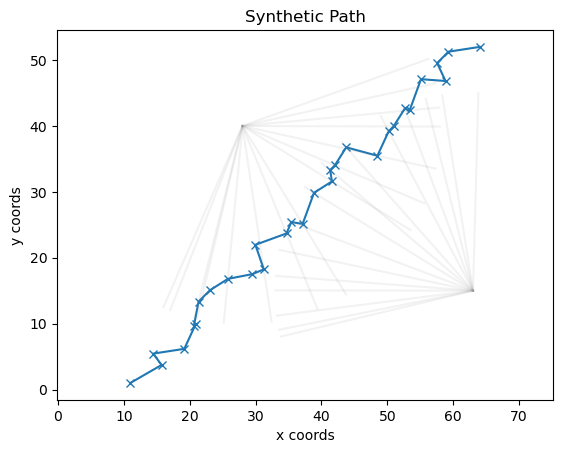

In [12]:
# Location of transmitters
a = [28,40,0]
e = [63,15,0]
stationlocations = np.array([a,e])
# Time for each observation in order that observations are stored in observations[]
obstimes = np.linspace(0,5,30)

# Populate observations[] with [x, y, z] vectors
observations = []
trueLocations = []
for i,t in enumerate(obstimes):
    location = np.array([(1*t)*10+10 + np.random.randint(1,5),(1*t)*10 + np.random.randint(1,5),0])
    vect = location-stationlocations
    vect/= np.linalg.norm(vect,axis=1)[:,None]
    possibleobs = np.c_[stationlocations,vect]
    obs = possibleobs[i%2,:]
    observations.append(obs)
    trueLocations.append(location)
# observations[observer_x, observer_y, observer_z (unused), observation_x, observation_y, observation_z (unused)]
# NOTE: Need to convert bearing in radians to directional vector
# V.x = cos(B)
# V.y = sin(B)
observations = np.array(observations)
# Tuples of x,y,z(unused) coords in order
trueLocations = np.array(trueLocations)

# Plot synthetic data
plt.axis('equal')
plt.plot(trueLocations[:,0],trueLocations[:,1],'x-')
plt.axis('equal')
for obs in observations:
    plt.plot([obs[0],obs[0]+obs[3]*30],[obs[1],obs[1]+obs[4]*30],color='grey',alpha=0.1)
plt.title("Synthetic Path")
plt.xlabel("x coords")
plt.ylabel("y coords")
plt.show()

Initiate VI object and run it:

In [14]:
inferredPath = Path(obstimes, observations, kernel = ExponentiatedQuadratic(lengthScale = 5,scaleFactor = 50), 
                    noiseScale=0.2, numberOfInducingPoints=7, inducingPointRange=0.1)
inferredPath.Run(400,0.3)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
At iteration: 0  loss is: [nan]
Increasing jitter to 0.00001
At iteration: 0  loss is: [nan]
Increasing jitter to 0.00010
At iteration: 0  loss is: [nan]
Increasing jitter to 0.00100
At iteration: 0  loss is: [617344.9]


2024-10-29 14:35:33.328234: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-29 14:35:33.410651: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-29 14:35:33.445076: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


At iteration: 50  loss is: [261060.67]
At iteration: 100  loss is: [99320.125]
At iteration: 150  loss is: [35753.38]
At iteration: 200  loss is: [12644.495]
At iteration: 250  loss is: [4760.05]
At iteration: 300  loss is: [2123.7544]
At iteration: 350  loss is: [1181.7981]
Training successful!


Plot loss:

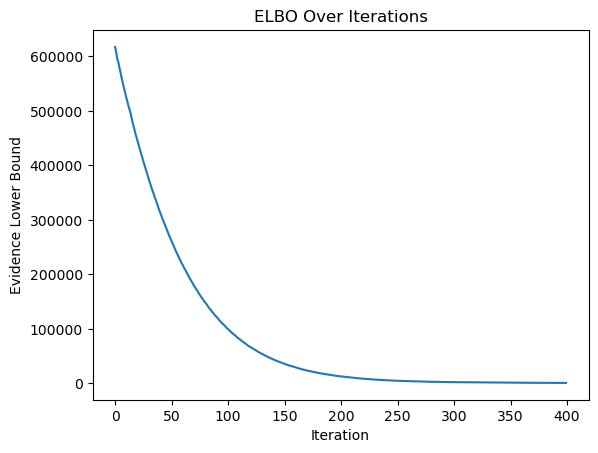

In [16]:
plt.plot(inferredPath.lossHistory)
plt.title("ELBO Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Evidence Lower Bound");

Infer a path:

In [18]:
# Mean and covariance of path - mu & sigma respectively
mu, sigma = inferredPath.Inference(100)

Plot path:

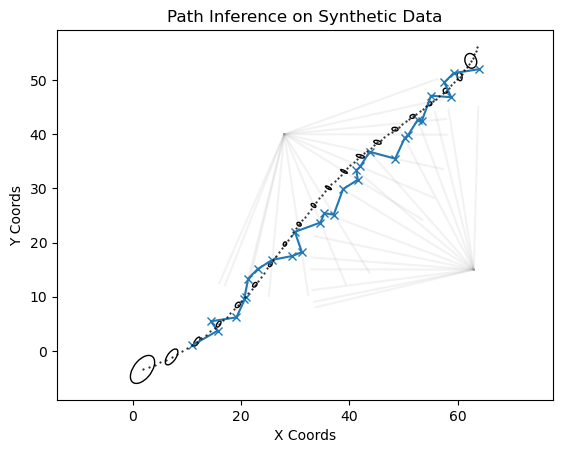

In [20]:
plt.axis('equal')
plt.plot(trueLocations[:,0],trueLocations[:,1],'x-')
plt.axis('equal')
for obs in observations:
    plt.plot([obs[0],obs[0]+obs[3]*30],[obs[1],obs[1]+obs[4]*30],color='grey',alpha=0.1)

ax = plt.gca()
for i,(m,c) in enumerate(zip(mu.numpy(),sigma.numpy())):
    std = max(np.sqrt(c[0,0]),np.sqrt(c[1,1]))
    plt.plot(m[0],m[1],'.k',markersize=1)

    if i%5==0:
        el = confidence_ellipse(m[:2],c[:2,:2],ax)
        ax.add_patch(el)
plt.xlabel("X Coords")
plt.ylabel("Y Coords")
plt.title("Path Inference on Synthetic Data")
plt.show()

# Loading & Processing Receiever Data


Load file helper function:

In [23]:
def LoadFile(fileName):
  with open(fileName, 'r') as f:
    filedata = f.read()
    return filedata

Functions to load in a file from either a .pcap file (off a tag) or a .log file (produced by active_scanner.c running on a DA14531 dev board):

In [25]:
# Split data from dev board active_scanner.c into packets
def ParseDataFromDevBoard(file, transmitterIDs, angleOffset, timeOffset):
    splitFile = file[54:].split('\n\n')
    splitFile = splitFile[1:len(splitFile)-1]
    data = []
    for i in range(len(splitFile)):
      if(len(splitFile[i]) == 29) and splitFile[i][27:28] in transmitterIDs:
        dataPoint = []
        dataPoint.append(-int(splitFile[i][7:9])) # RSSI
        dataPoint.append(splitFile[i][27:28]) # ID
        dataPoint.append(int(int(splitFile[i][23:25] + splitFile[i][26:27], 16))) # Angle (need to standardize between 0 and 359 degrees)
        dataPoint.append(int(splitFile[i][14:16] + splitFile[i][17:19] + splitFile[i][20:22], 16) - timeOffset) # Relative time 
        data.append(dataPoint)

    # Standardize the angles
    maximum = max([x[2] for x in data])
    minimum = min([x[2] for x in data])
    for x in range(len(data)):
      data[x][2] = 359 *  ((data[x][2] - minimum) / (maximum-minimum))

    # Apply angle offset
    for x in range(len(data)):
      data[x][2] = np.deg2rad((data[x][2] + angleOffset) % (maximum+1))

    return data

def ParseDataFromPcapPaste(file, transmitterIDs, angleOffset, timeOffset):
    splitFile = file.split('\n')

    rawPackets = []

    for packet in splitFile:
        packet = packet.split('\t')[3]
        rawPackets.append(packet)

    data = []
    for packet in set(rawPackets):
        if packet[-1] in transmitterIDs:
            dataPoint = []
            dataPoint.append(-int(packet[0:2],16)) # RSSI
            dataPoint.append(packet[-1]) # ID
            dataPoint.append(int(packet[-5:-3] + packet[-2], 16)) # ANGLE
            dataPoint.append(int(packet[3:5] + packet[6:8] + packet[9:11],16) - timeOffset)
            data.append(dataPoint)
            
    # Standardize the angles
    maximum = max([x[2] for x in data])
    minimum = min([x[2] for x in data])
    for x in range(len(data)):
      data[x][2] = 359 *  ((data[x][2] - minimum) / (maximum-minimum))

    # Apply angle offset
    for x in range(len(data)):
      data[x][2] = np.deg2rad((data[x][2] + angleOffset) % (maximum+1))

    return data

# Gets packets for a given transmitter id, with an applied angle and time offset if needed
# Outputs packets in form [RSSI, Angle, Time]
def PrepareData(filename, id, angleOffset = 0, timeOffset = 0, fileType = "log"):
    transmitterProfile = []
    if fileType == "log":
        transmitterProfile = np.array(ParseDataFromDevBoard(LoadFile(filename), ['a','b','c','d','e','f'], angleOffset, timeOffset))
    elif fileType == "pcap":
        transmitterProfile = np.array(ParseDataFromPcapPaste(LoadFile(filename), ['a','b','c','d','e','f'], angleOffset, timeOffset))
    data = transmitterProfile[transmitterProfile[:, 1] == id][:, [0, 2, 3]].astype(float)
    data = data[np.argsort(data[:, -1]), :]
    return data

First, load an antenna profile empirically measured using dev board:

In [27]:
# Load profile of antenna
antennaProfile = PrepareData("no rf amp experiments/noamploc2long.log", 'd', angleOffset = 38, timeOffset = 0)

Visualise the loaded profile:

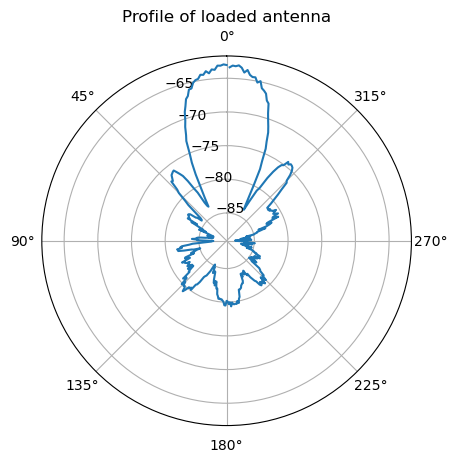

In [29]:
# Averages the signal strength at each angle of the transmitter's rotation over time
def AverageRSSIsAtAngle(data):
    uniqueAngles = set(data[:, 1])
    avgRSSIatAngle = []
    for angle in uniqueAngles:
        angleAvg = []
        for packet in data:
            if packet[1] == angle:
                angleAvg.append(packet[0])
        avgRSSIatAngle.append(np.mean(angleAvg))
        angleAvg = []
    return np.array(sorted(np.c_[list(uniqueAngles), list(avgRSSIatAngle)], key=lambda x: x[0]))

RSSIAverages = AverageRSSIsAtAngle(antennaProfile)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
plt.plot(RSSIAverages[:, 0], RSSIAverages[:, 1])
plt.title("Profile of loaded antenna");

Now define filepath containing observations from which inference should take place and the transmitters in the file.

transmitters[] should contain:
* id
* [x, y, z] coordinates of transmitter
* time offset (first transmitter turned on should be offset by zero, all others should be offset by the time taken to turn them on after the first transmitter was turned on)
* angle offset (probably not required - mainly used for loading in profile)

In [31]:
# Define filepath of data
fileToInfer = "/Users/chris/Desktop/Jul26- Two One-Antenna Transmitters/Path 2/pathtest2.log"
# Define transmitters [id, [x, y, z], time offset, angle offset]
transmitters = [['a', [28,40,0], 0, 0], ['e', [63,15,0], 36, 0]]

# TODO: Catch under defined/over defined antenna ids in file

# Load all data into testData[]
testData = []
for transmitter in transmitters:
    testData.append(PrepareData(fileToInfer, transmitter[0], angleOffset = transmitter[3], timeOffset = transmitter[2]))

In [32]:
#testData.append(PrepareData("no rf amp experiments/Untitled.txt", 'a', 0, 0, fileType = "pcap"))

Visualise loaded signal strengths:

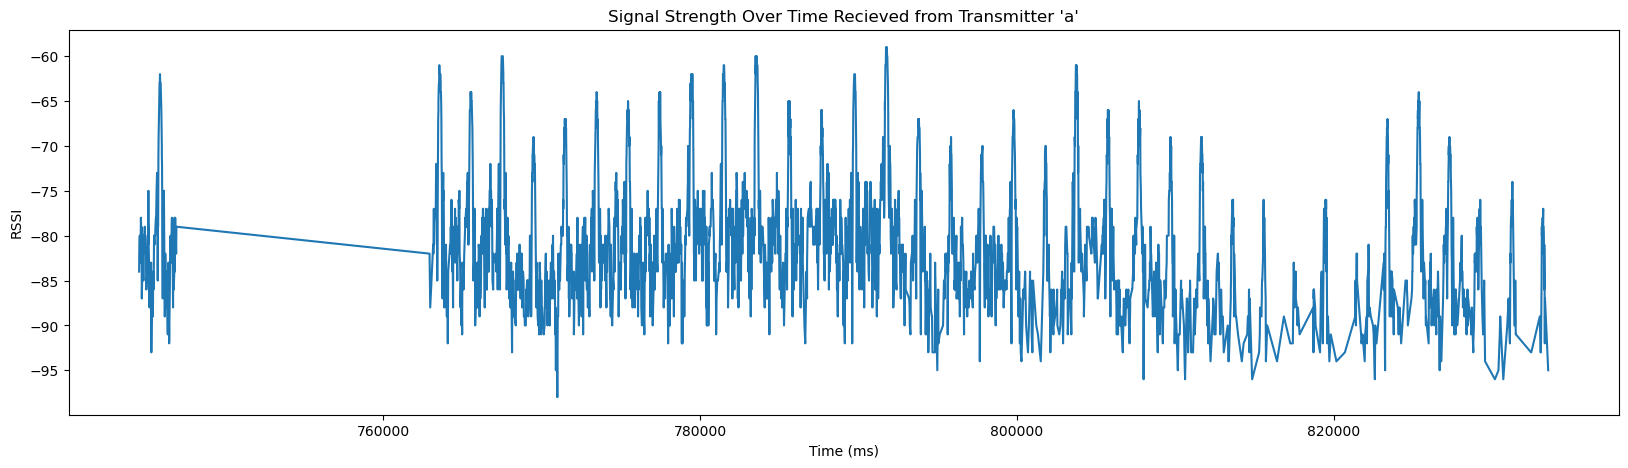

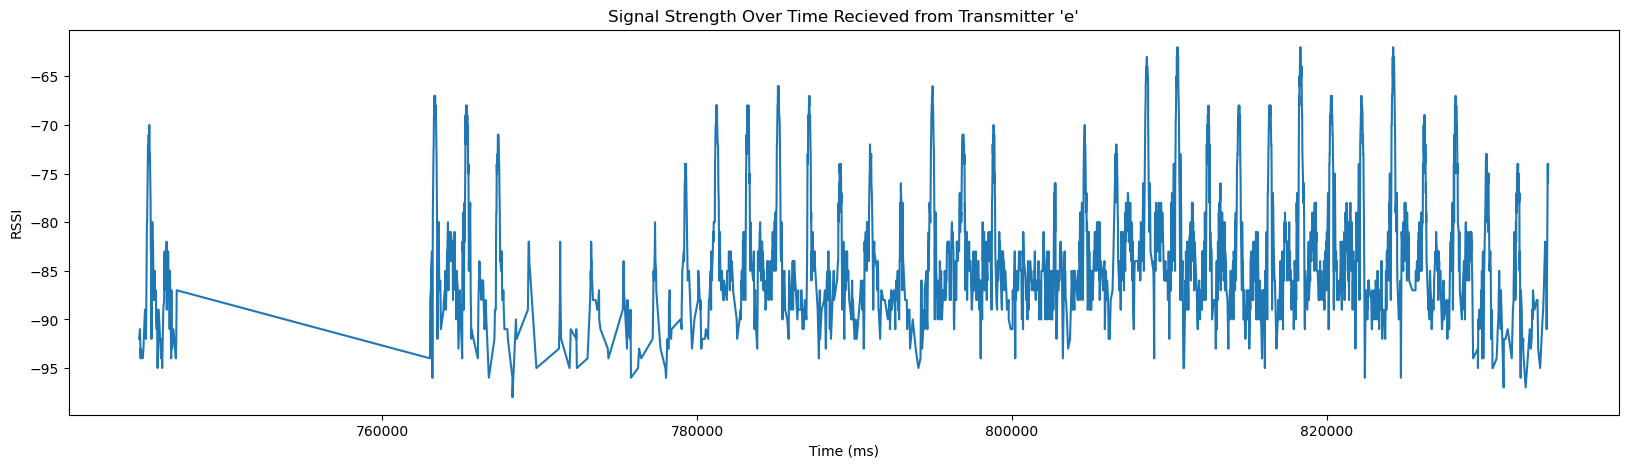

In [34]:
for id, data in enumerate(testData):
    plt.figure(figsize=[20, 5])
    plt.plot(data[:, 2], data[:, 0])
    plt.title("Signal Strength Over Time Recieved from Transmitter '" + transmitters[id][0] + "'")
    plt.ylabel("RSSI")
    plt.xlabel("Time (ms)")

Can cut off the ends of the data if needed (optional):

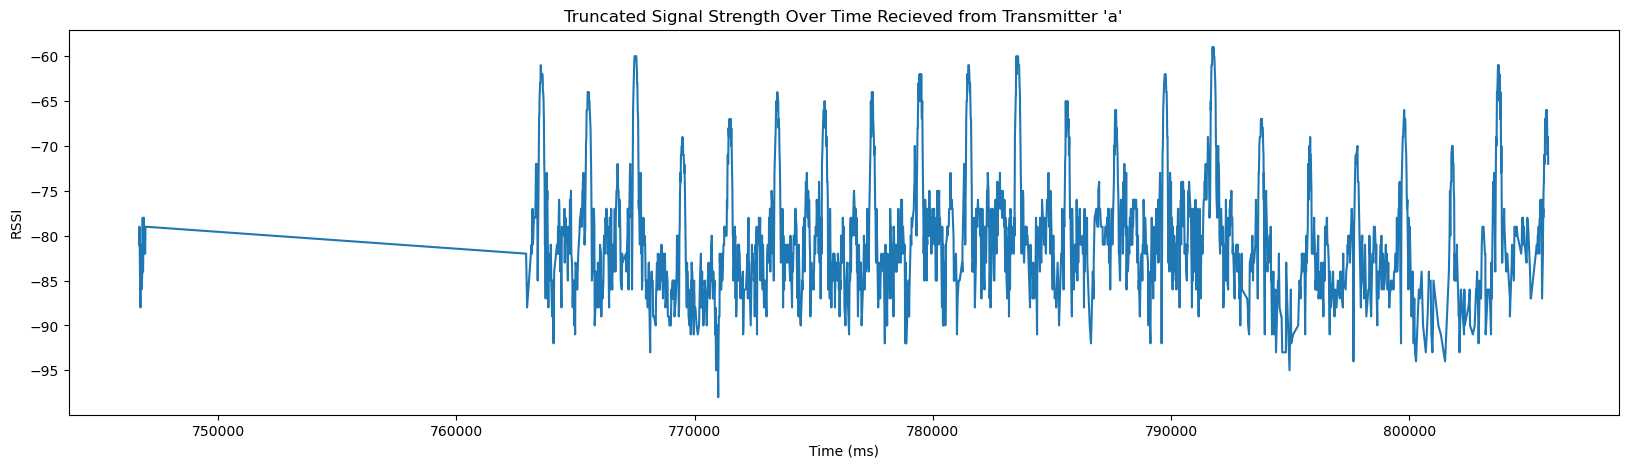

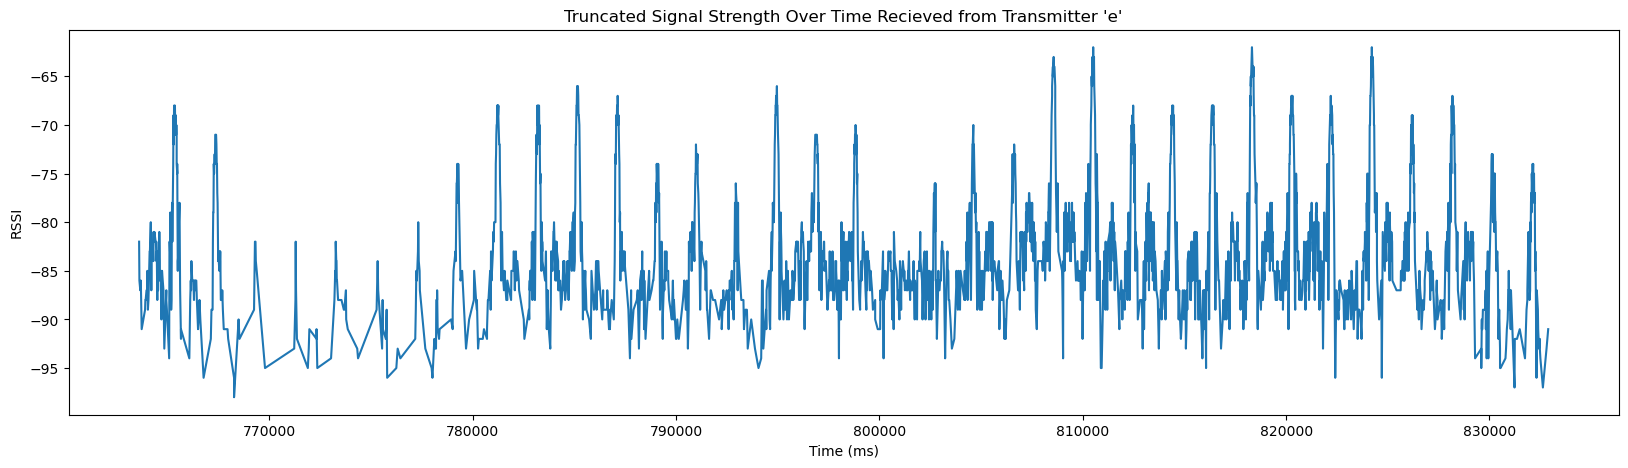

In [36]:
for dataIndex in range(len(testData)):
    testData[dataIndex] = testData[dataIndex][int(len(data)*0.05):int(len(data)*0.99)]

for id, data in enumerate(testData):
    plt.figure(figsize=[20, 5])
    plt.plot(data[:, 2], data[:, 0])
    plt.title("Truncated Signal Strength Over Time Recieved from Transmitter '" + transmitters[id][0] + "'")
    plt.ylabel("RSSI")
    plt.xlabel("Time (ms)")

# Angle Inference via Rejection Sampling

Build the training record from which rejection sampling will take place:

In [79]:
# Function to get a series of time separated samples
def GetSample(data, time):
    times = np.array([time - 300, time - 100, time + 100, time + 300, time])
    idxs = np.argmin(np.abs(data[:, -1:] - times[None, :]), 0)
    sigs = data[idxs, 0]
    signaldiffs = sigs[:-1] - sigs[-1]
    return signaldiffs, data[idxs, 1][-1], data[idxs, 0]

# Build rejection table from antenna profile
def BuildTrainingRecord(data):
    record = []
    mint, maxt = np.min(data[:, -1]), np.max(data[:, -1])
    for i, t in enumerate(np.arange(mint + 100e3, maxt, 50)):
        signalstrengths, angle, rawss = GetSample(data, t)
        #if np.mean(rawss)<np.mean(avgss)+3: continue ### IS IT A GOOD IDEA TO REMOVE FROM THE TRAINING SIGNALS THAT <3dB ABOVE AVG??!?
        record.append([t] + list(signalstrengths) + [angle])
        if (i % 1000 == 0):
            print(str(int(t - mint)) + "ms out of " + str(int(maxt - mint)) + "ms added to table.")
    print("Rejection table built of " + str(int(maxt-mint)) + "ms of antenna profile.")
    return np.array(record)

trainingRecord = BuildTrainingRecord(antennaProfile)

100000ms out of 733482ms added to table.
150000ms out of 733482ms added to table.
200000ms out of 733482ms added to table.
250000ms out of 733482ms added to table.
300000ms out of 733482ms added to table.
350000ms out of 733482ms added to table.
400000ms out of 733482ms added to table.
450000ms out of 733482ms added to table.
500000ms out of 733482ms added to table.
550000ms out of 733482ms added to table.
600000ms out of 733482ms added to table.
650000ms out of 733482ms added to table.
700000ms out of 733482ms added to table.
Rejection table built of 733482ms of antenna profile.


Use rejection sampling from the empirically measured training record to infer probable angles across the loaded data

In [117]:
# TODO: Allow definition of parameters for angle inference in function call
def ComputePredictions(data, record, filterOutput = True):
    mint, maxt = np.min(data[:, -1]), np.max(data[:, -1])
    predictions = []
    avgss = [1000] * 20
    plt.figure(figsize=[90, 8])
    for i, t in enumerate(np.arange(mint, maxt, 20)):    
        ss, ang, rawss = GetSample(data, t)
        del avgss[:1]
        avgss.append(rawss[-1])

        select = np.all(np.abs(ss - record[:, 1:-1]) < 6, 1) #all 5 measurements must be <6 dB out
        #select = np.sum(np.abs(ss-record[:,1:-1]),1)<10 #sum of errors <10dB
        predangle = record[select, -1] 
        predangle -= ang
        predangle[predangle < 0] += np.pi * 2
        predangle[predangle > 2 * np.pi] -= np.pi * 2
        predangle = 2 * np.pi - predangle
        
        plt.plot(t,(rawss[-1]+60)/10,'r+')

        if (filterOutput == True):
            if np.mean(rawss[-1]) < np.mean(avgss) + 10: continue
            if len(predangle) < 10: continue
            if (np.std(predangle) > 0.05): continue
            plt.plot(np.repeat(t, len(predangle)), predangle, '.k', markersize = 20, alpha = 0.01)
            plt.title("Inferred Angles over Time with Filtering", fontdict={'fontsize': 50})
        else:
            plt.plot(np.repeat(t, len(predangle)), predangle, '.k', markersize = 3, alpha = 0.01)
            plt.title("Inferred Angles over Time without Filtering", fontdict={'fontsize': 50})

        plt.xlabel("Time (ms)", fontdict={'fontsize': 35})
        plt.ylabel("RSSI (dBm) / Angle (radians)", fontdict={'fontsize': 35})
        
        predictions.append([t, np.mean(predangle)])
        
    plt.grid()
    plt.show()
    return predictions

Angle inference with no filtering:

Transmitter 'a':


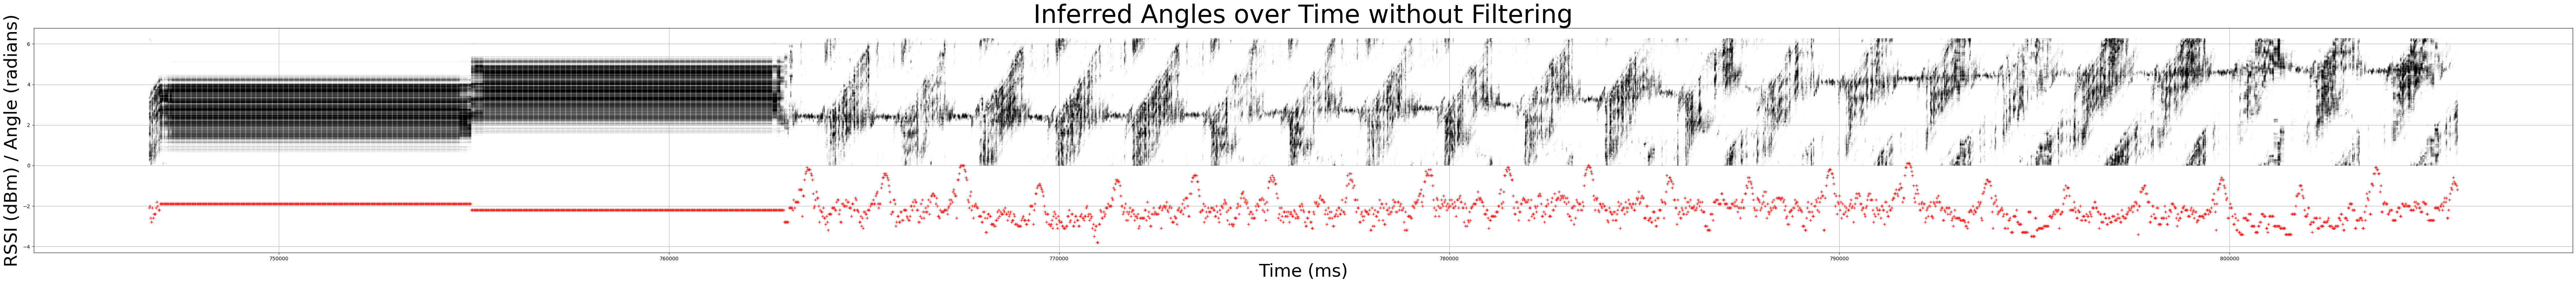

Transmitter 'e':


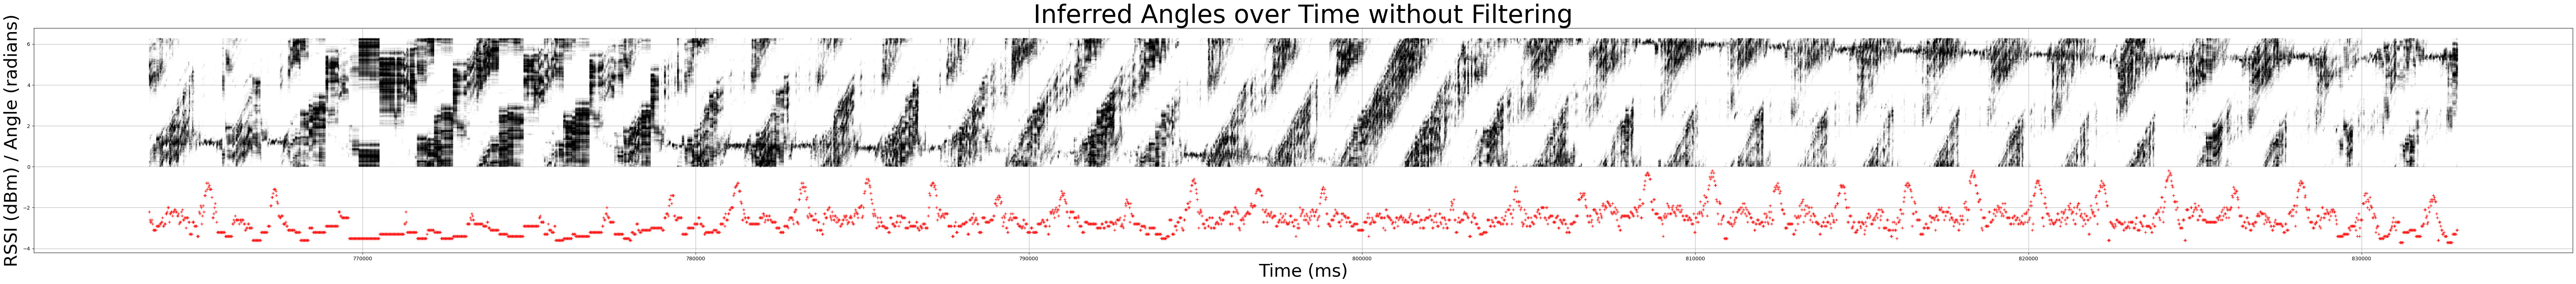

In [120]:
for i in range(len(transmitters)):
    print("Transmitter '" + transmitters[i][0] + "':")
    ComputePredictions(testData[i], trainingRecord, filterOutput = False)

Angle inference with filtering:

Transmitter 'a':


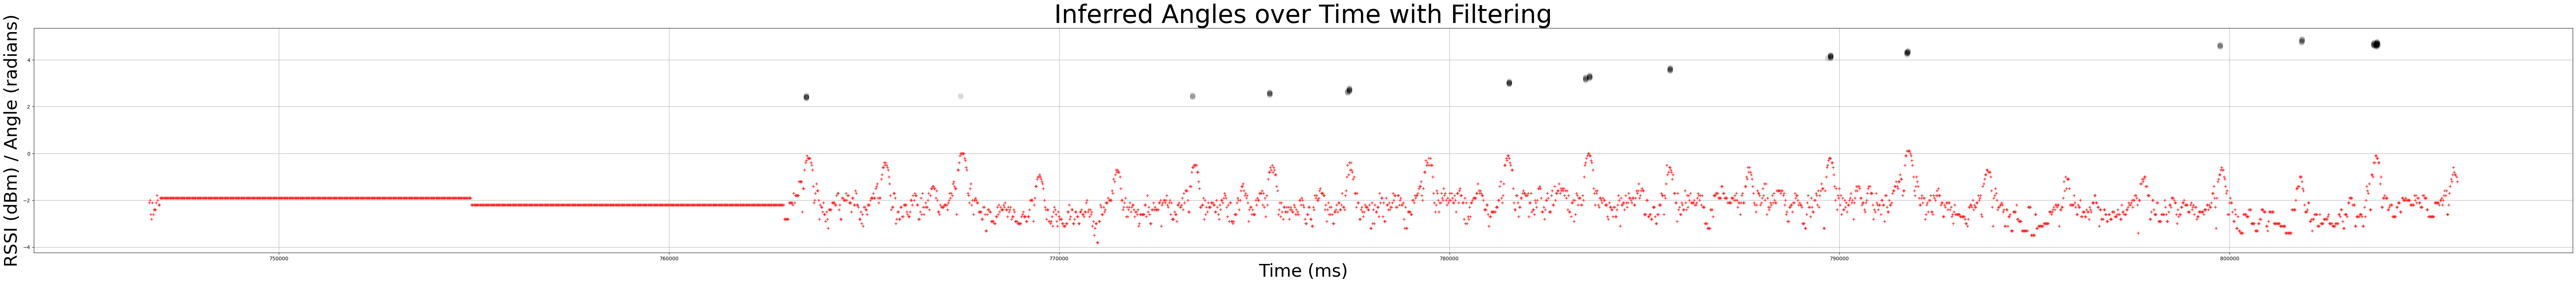

Transmitter 'e':


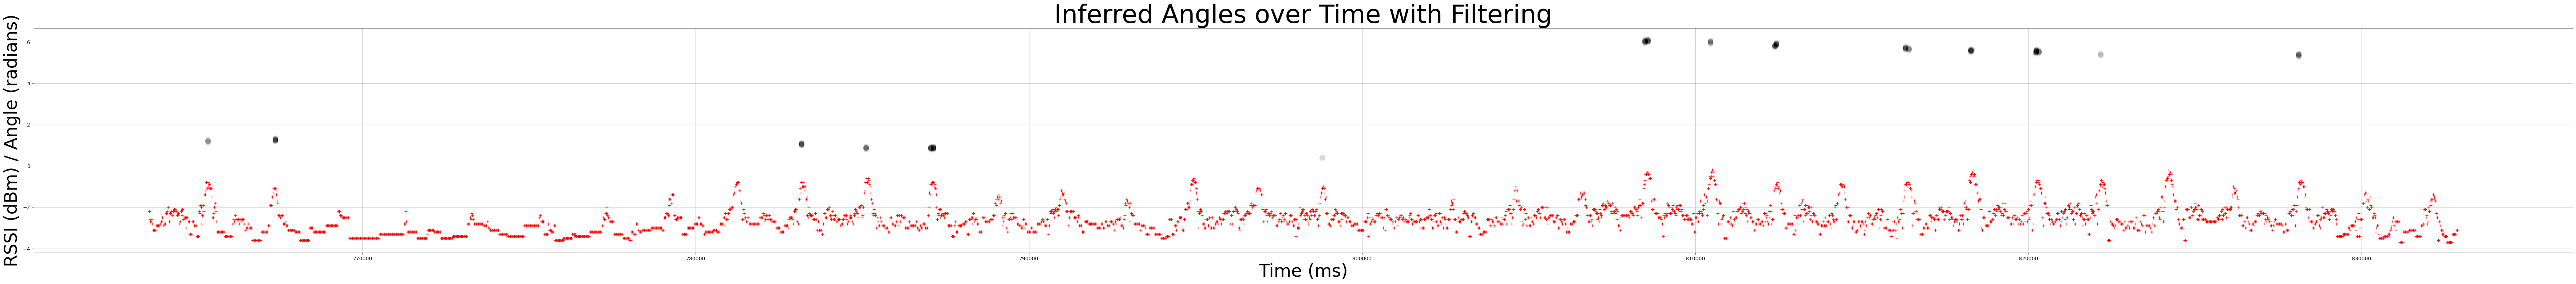

In [122]:
predictions = []
for i in range(len(transmitters)):
    print("Transmitter '" + transmitters[i][0] + "':")
    prediction = ComputePredictions(testData[i], trainingRecord)
    predictions.append(prediction)

Convert angles to vectors and populate predictionVectors[transmitterIndex] with the vectors and predictionTimes[transmitterIndex] with each predicted vectors' corresponding time of observation.

In [126]:
# Turn anti-clockwise angle (radians) into x, y, z vector
def AngleToVector(angle):
    # V.x = cos(B)
    # V.y = sin(B)
    vector = [0,0,0]
    vector[0] = -np.sin(angle)
    vector[1] = np.cos(angle)
    return vector

# Construct vector and time arrays from predictions
def ConstructPredictions(anglesFromTransmitters):
    predictionVectors = []
    predictionTimes = []
    for i in anglesFromTransmitters:
        currentTransmitterPredictions = []
        currentTransmitterPredictionTimes = []
        for j in i:
            currentTransmitterPredictions.append(AngleToVector(j[1]))
            currentTransmitterPredictionTimes.append(j[0])
        predictionVectors.append(currentTransmitterPredictions)
        predictionTimes.append(currentTransmitterPredictionTimes)
    return predictionVectors, predictionTimes

predictionVectors, predictionTimes = ConstructPredictions(predictions)

Plot the inferred angles:

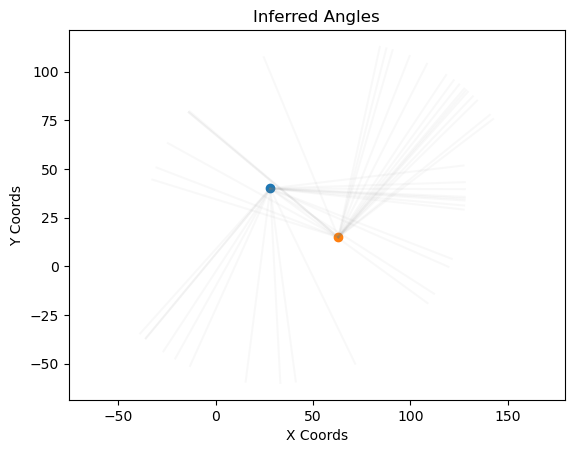

In [129]:
plt.axis('equal')
for i in range(len(transmitters)):
    transmitterX = transmitters[i][1][0]
    transmitterY = transmitters[i][1][1]
    plt.scatter(x = transmitterX, y = transmitterY)
    for obs in predictionVectors[i]:
        plt.plot([transmitterX, transmitterX+obs[0]*100],[transmitterY,transmitterY+obs[1]*100],color='grey',alpha=0.05)
    plt.xlabel("X Coords")
    plt.ylabel("Y Coords")
    plt.title("Inferred Angles")

# Path Inference on Inferred Angles

Add transmitter locations to predicted vectors:

In [133]:
for i in range(len(transmitters)):
    for vector in predictionVectors[i]:
        vector.insert(0,transmitters[i][1][2])
        vector.insert(0,transmitters[i][1][1])
        vector.insert(0,transmitters[i][1][0])

Construct input matrices for VI:

In [136]:
# Flatten and convert each to np arrays
observations = []
for i in range(len(transmitters)):
    observations += predictionVectors[i]
observations = np.array(observations)

# Scale down time
obsTimes = []
for i in range(len(transmitters)):
    obsTimes += predictionTimes[i]
obsTimes = np.array(obsTimes) / 10000

Create path object and define hyperparameters:

In [139]:
#WORKED WELL FOR PATH 2
inferredPath = Path(obsTimes, observations, kernel = ExponentiatedQuadratic(lengthScale = 50,scaleFactor = 50), 
             noiseScale=1, numberOfInducingPoints=15, inducingPointRange=0.05)

# WORKED WELL FOR PATH 5
#inferredPath = Path(obsTimes, observations, kernel = ExponentiatedQuadratic(lengthScale = 10,scaleFactor = 50), 
#             noiseScale=1, numberOfInducingPoints=500, inducingPointRange=0.10)

Run inference:

In [142]:
inferredPath.Run(500,0.5)

2024-10-29 14:41:39.604193: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-29 14:41:39.679025: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-29 14:41:39.716290: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-10-29 14:41:39.752185: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


At iteration: 0  loss is: [nan]
Increasing jitter to 0.00001
At iteration: 0  loss is: [nan]
Increasing jitter to 0.00010
At iteration: 0  loss is: [nan]
Increasing jitter to 0.00100
At iteration: 0  loss is: [nan]
Increasing jitter to 0.01000
At iteration: 0  loss is: [40037.03]
At iteration: 50  loss is: [14067.049]
At iteration: 100  loss is: [4913.2573]
At iteration: 150  loss is: [2188.3577]
At iteration: 200  loss is: [1255.7058]
At iteration: 250  loss is: [807.9887]
At iteration: 300  loss is: [576.6445]
At iteration: 350  loss is: [459.05557]
At iteration: 400  loss is: [407.43405]
At iteration: 450  loss is: [383.52936]
Training successful!


Make predictions:

In [144]:
mu, sigma = inferredPath.Inference(100)

Plot path inferred!

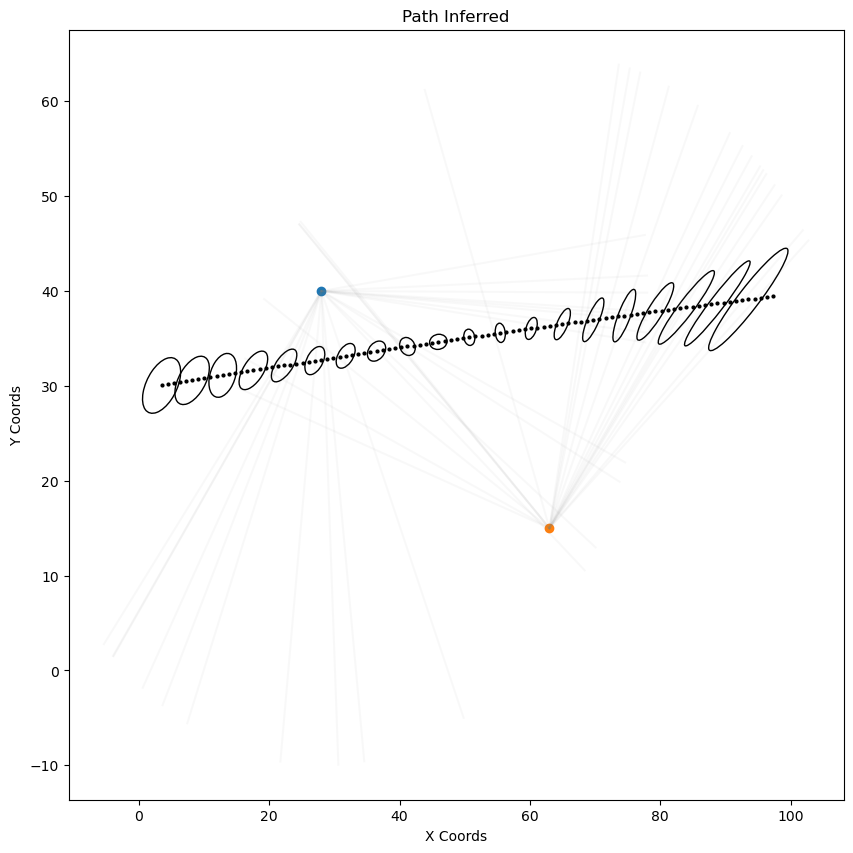

In [156]:
plt.figure(figsize=[10, 10])

predictionVectors, predictionTimes = ConstructPredictions(predictions)
for i in range(len(transmitters)):
    transmitterX = transmitters[i][1][0]
    transmitterY = transmitters[i][1][1]
    plt.scatter(x = transmitterX, y = transmitterY)
    for obs in predictionVectors[i]:
        plt.plot([transmitterX, transmitterX+obs[0]*50],[transmitterY,transmitterY+obs[1]*50],color='grey',alpha=0.05)
        
ax = plt.gca()
for i,(m,c) in enumerate(zip(mu.numpy(),sigma.numpy())):
    std = max(np.sqrt(c[0,0]),np.sqrt(c[1,1]))
    plt.plot(m[0],m[1],'.k',markersize=4)
    if i%5==0:
        el = confidence_ellipse(m[:2],c[:2,:2],ax, n_std=4)
        ax.add_patch(el)

plt.xlabel("X Coords")
plt.ylabel("Y Coords")
plt.title("Path Inferred")
plt.savefig('path.png', transparent=True)